# Concept 2: Dynamical System

@[Chaoming Wang](https://github.com/chaoming0625)

BrainPy supports modelings in brain simulation and brain-inspired computing.

All these supports are based on one common concept: **Dynamical System** via ``brainpy.DynamicalSystem``.

Therefore, it is essential to understand:
1. what is ``brainpy.DynamicalSystem``?
2. how to define ``brainpy.DynamicalSystem``?
3. how to run ``brainpy.DynamicalSystem``?

In [25]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

bp.__version__

'2.3.1'

## What is ``DynamicalSystem``?

All models used in brain simulation and brain-inspired computing is ``DynamicalSystem``.


```{note}
``DynamicalSystem`` is a subclass of ``BrainPyOject``. Therefore it supports to use [object-oriented transformations](./brainpy_transform_concept.ipynb) as stated in the previous tutorial.
```


A ``DynamicalSystem`` defines the updating rule of the model at single time step.

1. For models with state, ``DynamicalSystem`` defines the state transition from $t$ to $t+dt$, i.e., $S(t+dt) = F\left(S(t), x, t, dt\right)$, where $S$ is the state, $x$ is input, $t$ is the time, and $dt$ is the time step. This is the case for recurrent neural networks (like GRU, LSTM), neuron models (like HH, LIF), or synapse models which are widely used in brain simulation.

2. However, for models in deep learning, like convolution and fully-connected linear layers, ``DynamicalSystem`` defines the input-to-output mapping, i.e., $y=F\left(x, t\right)$.

![](imgs/dynamical_system.png)

## How to define ``DynamicalSystem``?

Keep in mind that the usage of ``DynamicalSystem`` has several constraints in BrainPy.

### 1. ``.update()`` function

First, *all ``DynamicalSystem`` should implement ``.update()`` function*, which receives two arguments:

```
class YourModel(bp.DynamicalSystem):
  def update(self, s, x):
    pass
```

- `s` (or named as others): A dict, to indicate shared arguments across all nodes/layers in the network, like
    - the current time ``t``, or
    - the current running index ``i``, or
    - the current time step ``dt``, or
    - the current phase of training or testing ``fit=True/False``.
- `x` (or named as others): The individual input for this node/layer.

We call `s` as shared arguments because they are same and shared for all nodes/layers. On the contrary, different nodes/layers have different input `x`.

**Example: LIF neuron model for brain simulation**

Here we illustrate the first constraint of ``DynamicalSystem`` using the Leaky Integrate-and-Fire (LIF) model.

The LIF model is firstly proposed in brain simulation for modeling neuron dynamics. Its equation is given by

$$
\begin{aligned}
\tau_m \frac{dV}{dt} = - (V(t) - V_{rest}) + I(t)  \\
\text{if} \, V(t) \gt V_{th}, V(t) =V_{rest}
\end{aligned}
$$

For the details of the model, users should refer to Wikipedia or other resource.


In [19]:
class LIF_for_BrainSimulation(bp.DynamicalSystem):
  def __init__(self, size, V_rest=0., V_th=1., tau=5., mode=None):
    super().__init__(mode=mode)

    # this model only supports non-batching mode
    bp.check.is_subclass(self.mode, bm.NonBatchingMode)

    # parameters
    self.size = size
    self.V_rest = V_rest
    self.V_th = V_th
    self.tau = tau

    # variables
    self.V = bm.Variable(bm.ones(size) * V_rest)
    self.spike = bm.Variable(bm.zeros(size, dtype=bool))

    # integrate differential equation with exponential euler method
    self.integral = bp.odeint(f=lambda V, t, I: (-V + V_rest + I)/tau, method='exp_auto')

  def update(self, s, x):
    # define how the model states update
    # according to the external input
    t, dt = s.get('t'), s.get('dt')
    V = self.integral(self.V, t, x, dt=dt)
    spike = V >= self.V_th
    self.V.value = bm.where(spike, self.V_rest, V)
    self.spike.value = spike
    return spike

### 2. Computing mode

Second, **explicitly consider which computing mode your ``DynamicalSystem`` supports**.

Brain simulation usually builds models without batching dimension (we refer to it as *non-batching mode*, as seen in above LIF model), while brain-inspired computation trains models with a batch of data (*batching mode* or *training mode*).

So, to write a model applicable to abroad applications in brain simulation and brain-inspired computing, you need to consider which mode your model supports, one of them, or both of them.

**Example: LIF neuron model for both brain simulation and brain-inspired computing**

When considering the computing mode, we can program a general LIF model for brain simulation and brain-inspired computing.

To overcome the non-differential property of the spike in the LIF model for brain simulation, i.e., at the code of

```python
spike = V >= self.V_th
```

LIF models used in brain-inspired computing calculate the spiking state using the surrogate gradient function. Usually, we replace the backward gradient of the spike with a smooth function, like

$$
g'(x) = \frac{1}{(\alpha * |x| + 1.) ^ 2}
$$

In [20]:
class LIF(bp.DynamicalSystem):
  def __init__(self, size, f_surrogate=None, V_rest=0., V_th=1., tau=5.,mode=None):
    super().__init__(mode=mode)
    bp.check.is_subclass(self.mode, [bm.NonBatchingMode, bm.BatchingMode, bm.TrainingMode])

    # Parameters
    self.size = size
    self.num = bp.tools.size2num(size)
    self.V_rest = V_rest
    self.V_th = V_th
    self.tau = tau
    if f_surrogate is None:
      f_surrogate = bm.surrogate.inv_square_grad
    self.f_surrogate = f_surrogate

    # integrate differential equation with exponential euler method
    self.integral = bp.odeint(f=lambda V, t, I: (-V + V_rest + I)/tau, method='exp_auto')

    # Initialize a Variable:
    # - if non-batching mode, batch axis of V is None
    # - if batching mode,     batch axis of V is 0
    self.V = bp.init.variable_(bm.zeros, self.size, self.mode)
    self.V[:] = self.V_rest
    self.spike = bp.init.variable_(bm.zeros, self.size, self.mode)

  def reset_state(self, batch_size=None):
    self.V.value = bp.init.variable_(bm.ones, self.size, batch_size) * self.V_rest
    self.spike.value = bp.init.variable_(bm.zeros, self.size, batch_size)

  def update(self, s, x):
    t, dt = s.get('t'), s.get('dt', bm.dt)
    V = self.integral(self.V, t, x, dt=dt)
    # replace non-differential heaviside function
    # with a surrogate gradient function
    spike = self.f_surrogate(V - self.V_th)
    # reset membrane potential
    self.V.value = (1. - spike) * V + spike * self.V_rest
    self.spike.value = spike
    return spike

### Model composition

The ``LIF`` model we have defined above can be recursively composed to construct networks in brain simulation and brain-inspired computing.

The following code snippet utilizes the LIF model to build an E/I balanced network ``EINet``, which is a classical network model in brain simulation.

In [21]:
class EINet(bp.DynamicalSystem):
  def __init__(self, num_exc, num_inh):
    super().__init__()
    self.E = LIF(num_exc, V_rest=-55, V_th=-50., tau=20.)
    self.I = LIF(num_inh, V_rest=-55, V_th=-50., tau=20.)
    self.E2E = bp.synapses.Exponential(self.E, self.E, bp.conn.FixedProb(0.02),
                                       g_max=1.62, tau=5., output=None)
    self.E2I = bp.synapses.Exponential(self.E, self.I, bp.conn.FixedProb(0.02),
                                       g_max=1.62, tau=5., output=None)
    self.I2E = bp.synapses.Exponential(self.I, self.E, bp.conn.FixedProb(0.02),
                                       g_max=-9.0, tau=10., output=None)
    self.I2I = bp.synapses.Exponential(self.I, self.I, bp.conn.FixedProb(0.02),
                                       g_max=-9.0, tau=10., output=None)

  def update(self, s, x):
    # x is the background input
    e2e = self.E2E(s)
    e2i = self.E2I(s)
    i2e = self.I2E(s)
    i2i = self.I2I(s)
    self.E(s, e2e + i2e + x)
    self.I(s, e2i + i2i + x)

with bm.environment(mode=bm.nonbatching_mode):
  net1 = EINet(3200, 800)

Moreover, our LIF model can also be used in brain-inspired computing scenario. The following ``AINet`` uses the LIF model to construct a model for AI training.

In [22]:
# This network can be used in AI applications

class AINet(bp.DynamicalSystem):
  def __init__(self, sizes):
    super().__init__()
    self.neu1 = LIF(sizes[0])
    self.syn1 = bp.layers.Dense(sizes[0], sizes[1])
    self.neu2 = LIF(sizes[1])
    self.syn2 = bp.layers.Dense(sizes[1], sizes[2])
    self.neu3 = LIF(sizes[2])

  def update(self, s, x):
    x = self.neu1(s, x)
    x = self.syn1(s, x)
    x = self.neu2(s, x)
    x = self.syn2(s, x)
    x = self.neu3(s, x)
    return x

with bm.environment(mode=bm.training_mode):
  net2 = AINet([100, 50, 10])

## How to run ``DynamicalSystem``?

As we have stated above that ``DynamicalSystem`` only defines the updating rule at single time step, to run a ``DynamicalSystem`` instance over time, we need a for loop mechanism.

![](./imgs/dynamical_system_and_dsrunner.png)

### 1. ``brainpy.math.for_loop``

``for_loop`` is a structural control flow API which runs a function with the looping over the inputs. Moreover, this API just-in-time compile the looping process into the machine code.

Suppose we have 200 time steps with the step size of 0.1, we can run the model with:

In [23]:
with bm.environment(dt=0.1):
  # construct a set of shared argument with the given time steps
  shared = bm.shared_args_over_time(num_step=200)
  # construct the inputs with shape of (time, batch, feature)
  currents = bm.random.rand(200, 10, 100)

  # run the model
  net2.reset_state(batch_size=10)
  out = bm.for_loop(net2, (shared, currents))

out.shape

(200, 10, 10)

### 2. ``brainpy.DSRunner``

Another way to run the model in BrainPy is using the structural running object ``DSRunner`` and ``DSTrainer``. They provide more flexible way to monitoring the variables in a ``DynamicalSystem``. The details users should refer to the [DSRunner tutorial](../tutorial_simulation/simulation_dsrunner.ipynb).


  0%|          | 0/1000 [00:00<?, ?it/s]

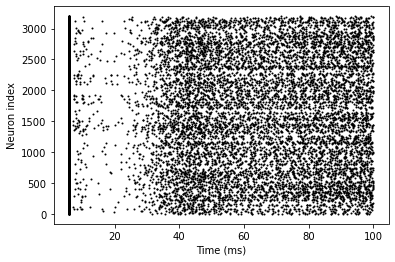

In [24]:
with bm.environment(dt=0.1):
  runner = bp.DSRunner(net1, monitors={'E.spike': net1.E.spike, 'I.sike': net1.I.spike})
  runner.run(inputs=bm.ones(1000) * 20.)

bp.visualize.raster_plot(runner.mon['ts'], runner.mon['E.spike'])